# Week 7 Transit Gaps Group Collaboration Notebook
## Team members: Monisha Reginald, Lucy Briggs, Carolyn Pugh

### Description
<b>Research Question</b>: Where do gaps in access to grocery stores by non-automobile modes exist for seniors who live in the city of Los Angeles?<br>
<b>Notbook Purpose:</b> In this notebook, we will consolidate and provide additional narrative around the work we have developed so far as part of our preparation for our final project.

### Import Libraries

In [1]:
#imprt libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import fiona 
import numpy as np
import math
import folium
from shapely.geometry import Point
import plotly.express as px

### Part 1: Where do senior residents live within the City of LA? 
In this section, we analyze which areas have higher or lower densities of older residents using census data.  We look at both the block group and neighborhood level.

### Seniors Basemap

In [2]:
#read our pre-made GeoJSON
seniors = gpd.read_file('data/Seniors_Basemap.geojson')
seniors.sample(5)

BG20   ShapeSTArea          FIPS  Total Pop  Age 65-74  Age 75-84  \
2199  1281012  2.623532e+06  060371281012        830         42         75   
2640  1153011  6.417490e+06  060371153011       1288        127         86   
2428  1313002  2.982432e+06  060371313002        776         84         22   
366   2693002  3.078879e+06  060372693002        664        136         32   
2773  3202012  3.636344e+06  060373202012       2102        118          0   

      Age 85+  Total Senior Pop  Pct Seniors  Square Miles  Pop Density  \
2199        0               117    14.096386      1.012947        116.0   
2640       73               286    22.204969      2.477795        115.0   
2428        0               106    13.659794      1.151518         92.0   
366         0               168    25.301205      1.188757        141.0   
2773        0               118     5.613701      1.403994         84.0   

       pctcat                                           geometry  
2199  10%-20%  POLYGON ((-118.43563 34.18850, -118.43672 34.1...  
2640  20%-40%  POLYGON ((-118.54417 34.25001, -118.54408 34.2...  
2428  10%-20%  POLYGON ((-118.51861 34.20841, -118.51970 34.2...  
366   20%-40%  POLYGON ((-118.41109 34.03906, -118.41166 34.0...  
2773   0%-10%  MULTIPOLYGON (((-118.44708 34.29302, -118.4470...

This is our age data basemap made previously in week 4 and 5. I'll include the code for creating the "pctcat" field so we can change the intervals if needed.

In [3]:
seniors.loc[seniors['Pct Seniors'].between(0,20), 'pctcat'] = '0%-20%'
seniors.loc[seniors['Pct Seniors'].between(20,40), 'pctcat'] = '20%-40%'
seniors.loc[seniors['Pct Seniors'] > 40, 'pctcat'] = '40%+'

List all of the different percent categories

In [4]:
pctcats = seniors['pctcat'].unique().tolist()

Create a funciton to make binary maps using a loop. 

In [5]:
def binary():    
    for pct in pctcats:
        fig, ax = plt.subplots(figsize=(5,5))

        # create the map plot
        seniors.plot(ax=ax,
                color='#bababa')

        # create the map plot
        seniors[seniors['pctcat'] == pct].plot(ax=ax,
                # column='pctcat',
                color='#018571')

        # add a title
        ax.set_title('Census Blocks with ' + pct + ' ' + 'Residents Age 65+')
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=4326)

        # get rid of the axis
        ax.axis('off');

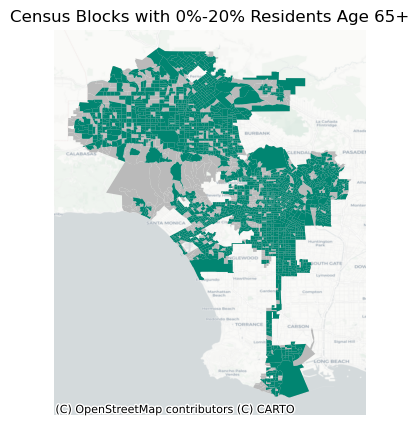

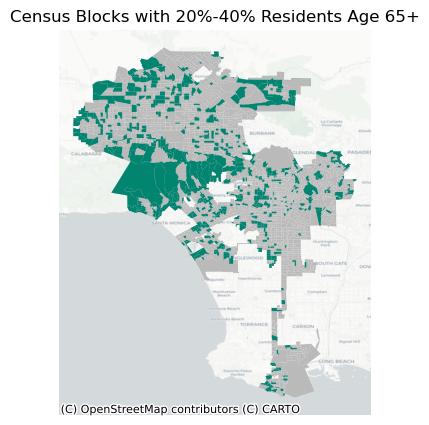

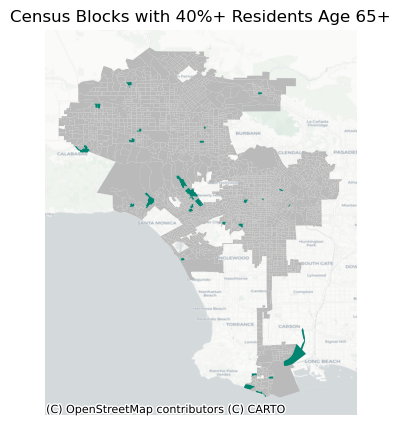

In [6]:
binary()

We can see the few tracts with the highest percentages of seniors. 

### Creating a Seniors Basemap by Neighborhood in addition to the Block Group data

In [7]:
# Import neighborhood boundaries directly from LA GeoHub.
neighborhoods=gpd.read_file(
    'https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/LA_Times_Neighborhoods/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson').to_crs('epsg:6423').rename(columns={'name' : 'neighborhood'})
neighborhoods = neighborhoods.to_crs(4326) #converting to the projection of our Seniors data

Steps: 

1. Join the neighborhood boundaries to our seniors data using a spatial join
2. Group by neighborhood and sum the other columns
3. Fix the percentages that were added up
4. Merge the new grouped dataframe with the original neighborhoods data to get the Geometry column back 

In [8]:
#spatial join to neighborhoods
seniors_join = gpd.sjoin(seniors, neighborhoods, how='right')

#group by neighborhood and add up the other columns
neighborhood_seniors = seniors_join.groupby(['neighborhood']).sum(numeric_only=True).reset_index()

#fix the percentage colums
neighborhood_seniors['Pct Seniors']=(neighborhood_seniors['Total Senior Pop']/neighborhood_seniors['Total Pop'])*100

#merge to neighborhoods to get the geometry column back
neighborhood_seniors=pd.merge(neighborhoods,neighborhood_seniors,how="left", 
                              on=['neighborhood']).drop(columns=['OBJECTID_y']).rename(columns={'OBJECTID_x' : 'OBJECTID'})

Now we should have a dataframe that shows our seniors data on the neighborhood level. Create a plot of the highest percentages of senior population. This chart is more useful than our original census block plot, as neighborhoods are more recognizable. 

In [9]:
#Sort to see the top groups
neighborhood_seniors.sort_values('Pct Seniors', inplace=True, ascending=False)

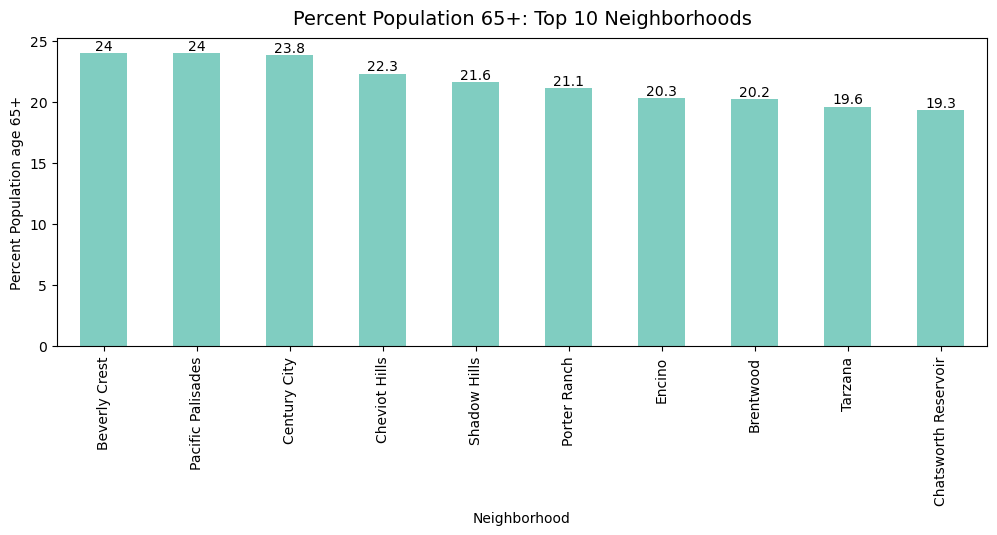

In [10]:
#plot the df
neighborhood_seniors.sort_values('Pct Seniors', inplace=True, ascending=False) #sort to see top 10
neighborhood_seniors['Pct Seniors'] = round(neighborhood_seniors['Pct Seniors'], 1) #round to one decimal place for bar labels
fig, ax = plt.subplots(figsize=(12,4))

neighborhood_seniors[:10].plot.bar(ax=ax,
                                      x='neighborhood',
                                      y='Pct Seniors',
                                      legend=False,
                                      color='#80cdc1'
                                      )
ax.bar_label(ax.containers[0], label_type='edge')
ax.set_xlabel('Neighborhood') # override x label
ax.set_ylabel('Percent Population age 65+') # override y label
ax.set_title("Percent Population 65+: Top 10 Neighborhoods",fontsize=14,pad=10); # multi-line title with padding

Beverly Crest is the neighborhood with the highest percentage of seniors age 65+. 

# Metro Micro

The Metro Micro zones represent areas that already have good access to grocery stores for seniors, as they allow seniors to access transit without walking far to or from their destination or a transit stop. The purpose of our project is to determine where the gaps in transit are across the city, so we must account for Metro Micro zones. In essence, we want to identify potential areas for additional Metro Micro expansion. 
To begin: import our metro micro geojson created in week 4.

In [11]:
micro = gpd.read_file('data/micro.geojson')
micro.sample(5)

name                                           geometry
7        Pasadena Altadena  POLYGON Z ((-118.13045 34.20416 0.00000, -118....
4  North Hollywood/Burbank  POLYGON Z ((-118.34073 34.14307 0.00000, -118....
6          UCLA / Westwood  POLYGON Z ((-118.42059 34.05032 0.00000, -118....
0        Watts Willowbrook  POLYGON Z ((-118.26535 33.95297 0.00000, -118....
5      San Fernando Valley  POLYGON Z ((-118.51977 34.23579 0.00000, -118....

# 

Map the metro micro zones with folium

In [12]:
m = folium.Map(location=[34.1,-118.3], 
               zoom_start = 10.45,
               tiles='CartoDB positron', 
               attribution='CartoDB')
#plot polygons
for _, r in micro.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': '#a6611a', "color": "#018571", 'weight': 1.5})
    folium.Popup(r['name']).add_to(geo_j)
    geo_j.add_to(m)
m

In [13]:
m.save('metromicro.html')

### Part 2: Where do Seniors Lack Access to a Vehicle in Los Angeles?

First, we read in the geojson created in the Prep Notebook, which contains information about vehicle ownership for all block groups in the City of Los Angeles.

In [14]:
vehicle_access=gpd.read_file('vehicle_access.geojson')

We are interested in vehicle ownership rates for the City of LA, so we will calcualte stats across the block groups.

In [15]:
# Calculate sum across all block groups (results in a series) and then convert that series to a dataframe.
city_totals=vehicle_access.sum(numeric_only=True).to_frame().transpose()

# Recalculate percentages.
city_totals['Pct Households Without a Vehicle']=(city_totals['Total No Vehicle']/city_totals['Total HH'])*100
city_totals['Pct Senior-Headed Households Without a Vehicle']=(city_totals['Senior No Vehicle']/city_totals['Senior HH'])*100

# Inspect results.
city_totals

Total HH  Senior HH  Total No Vehicle  Senior No Vehicle  \
0  1385427.0   287185.0          161724.0            58193.0   

   Pct Households Without a Vehicle  \
0                         11.673224   

   Pct Senior-Headed Households Without a Vehicle  
0                                       20.263245

We can see that seniors are almost twice as likely to lack access to a household vehicle. We will make a bar chart so that this information can be displayed visually in presentations.

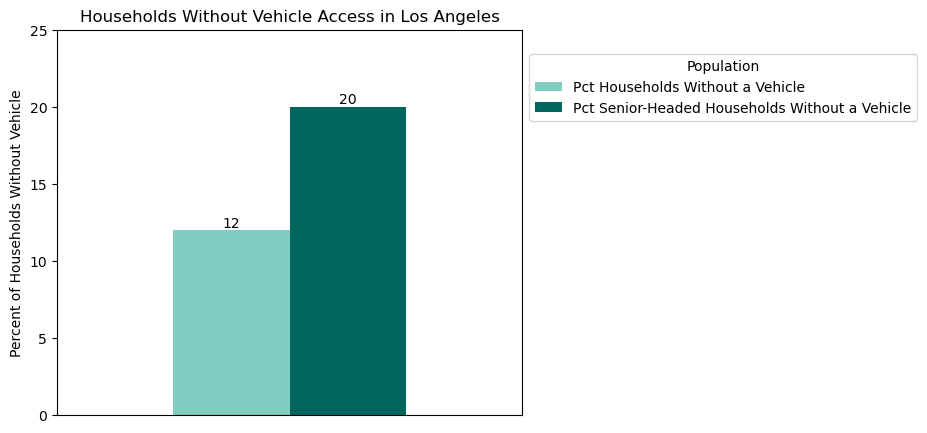

In [16]:
# Create a dataframe for chart with just rounded percentages (so that they can be displayed).
city_bar=city_totals[['Pct Households Without a Vehicle', 'Pct Senior-Headed Households Without a Vehicle']].round()

# Start plot.
fig, ax = plt.subplots(figsize=(6,5))

# Plot data and label the two bars with their values.
ax = city_bar.plot(ax=ax, kind='bar', color=['#80cdc1','#01665e'], legend=True)
ax.bar_label(ax.containers[0], label_type='edge')
ax.bar_label(ax.containers[1], label_type='edge')

# Adjust x-axis so it doesn't have a subtitle or ticks.
plt.xlabel(None)
ax.set_xticks([])

# Ajust y-axis so that it has desired subtitle and ticks.
plt.ylabel("Percent of Households Without Vehicle")
ax.set_yticks((0,5,10,15,20,25))

#Adjust table and legend.
plt.title("Households Without Vehicle Access in Los Angeles")
plt.legend(loc='center left', bbox_to_anchor=(1, .85), title='Population')

plt.show()

We want to understand how vehicle access and senior-vehicle access relate to each other, so we'll create a scatter plot.

Text(0.5, 1.0, 'Household Vehicle Access at Block Group Level')

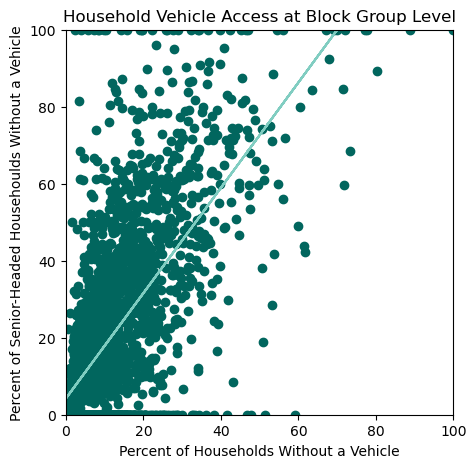

In [17]:
# Create filtered version that exclused all rows with missing data
census_linear=vehicle_access[(vehicle_access["Pct Households Without a Vehicle"]>=0) & (vehicle_access["Pct Senior-Headed Households Without a Vehicle"]>=0)]

# Calculate line of best fit for this filtered dataframe.
m, b = np.polyfit(census_linear["Pct Households Without a Vehicle"], census_linear["Pct Senior-Headed Households Without a Vehicle"], 1)

# Start plot
fig,ax = plt.subplots(figsize=(5,5))

# Plot all points and line of best fit.
ax = plt.plot(census_linear["Pct Households Without a Vehicle"], census_linear["Pct Senior-Headed Households Without a Vehicle"], 'o', color='#01665e')
ax = plt.plot(census_linear["Pct Households Without a Vehicle"], m*census_linear["Pct Households Without a Vehicle"] + b, color='#80cdc1')

plt.xlim(0,100)
plt.xlabel("Percent of Households Without a Vehicle")

plt.ylim(0,100)
plt.ylabel("Percent of Senior-Headed Househoulds Without a Vehicle")

plt.title("Household Vehicle Access at Block Group Level")

From this plot, we can see that vehicle ownership and senior vehicle ownership trend together, but that seniors are systematically less likely to own a vehicle than the general population.

Finally, we want to see this information visually mapped to understand geographic trends. We'll create a new version of this dataframe that replaces "N/A" values (which result when there are either no people or no seniors within a block group) with 0s, so that they are visually grouped with other areas where there is less need to invest in transit infrastructure.

In [18]:
# Create a new dataframe for mapping purposes.
vehicle_map=vehicle_access

# Set value of 0 on rows where the percentages are currently "N/A"
vehicle_map['Pct Households Without a Vehicle'] = vehicle_map['Pct Households Without a Vehicle'].fillna(0)
vehicle_map['Pct Senior-Headed Households Without a Vehicle'] = vehicle_map['Pct Senior-Headed Households Without a Vehicle'].fillna(0)

We want to map the block groups pased on their senior vehicle-ownership percentages, so we'll categorize them based on areas with no vehicle-free househoulds, areas where 0-20% of senior-headed households lack a vehicle, and areas where over 20% (the City average) of senior-headed households lack a vehicle. Note that these percentages can be adjusted.

In [19]:
# First we have to sort and re-index this dataframe so the row number corresponds to its rank.
vehicle_map=vehicle_map.sort_values(by=['Pct Senior-Headed Households Without a Vehicle']).reset_index().drop(columns=['index'])

# Categorize rows according to their row percentile
vehicle_map['Senior_Category']= '0% of Senior-Headed Households Lack Vehicle'
vehicle_map.loc[vehicle_map['Pct Senior-Headed Households Without a Vehicle'] > 0, 'Senior_Category'] = "1-20% of Senior-Headed Households Lack Vehicle"
vehicle_map.loc[vehicle_map['Pct Senior-Headed Households Without a Vehicle'] > 20, 'Senior_Category'] = "Over 20% of Senior-Headed Households Lack Vehicle"

Now we can make the map!

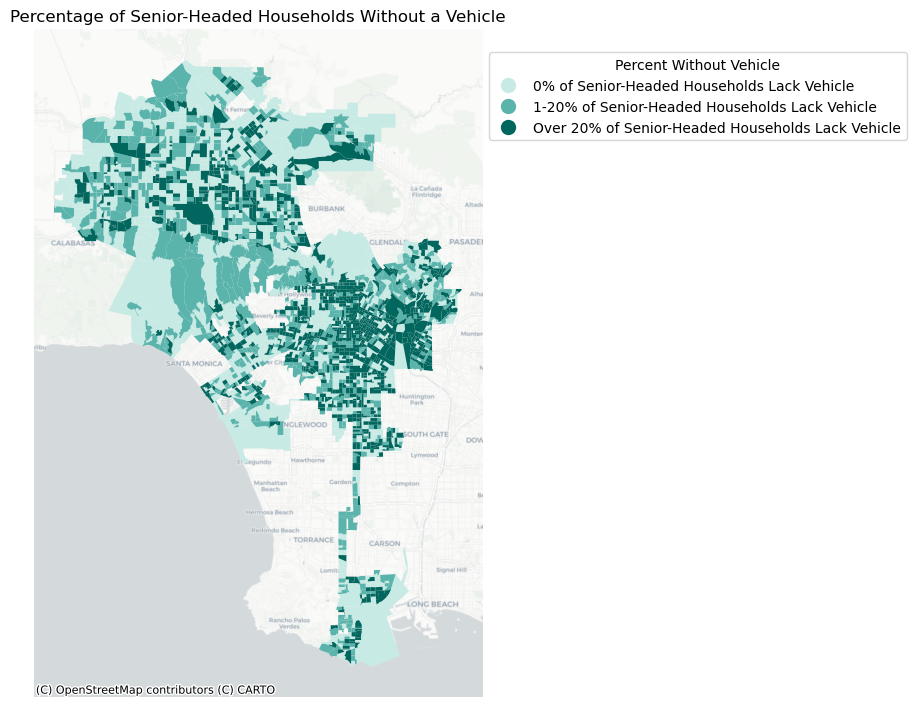

In [20]:
# Since Python doesn't want me to specific a color and a colomn within the same plot, I'll first create a color column and then a manual legend.
color_dict = {'0% of Senior-Headed Households Lack Vehicle' : '#c7eae5',
              '1-20% of Senior-Headed Households Lack Vehicle': '#5ab4ac',
              'Over 20% of Senior-Headed Households Lack Vehicle': '#01665e'}

vehicle_map["colors"] = vehicle_map["Senior_Category"].map(color_dict)

# Now I create my actual map with the three geodataframes added in the appropriate order (zorder).
fig,ax = plt.subplots(figsize=(8,8))
ax = vehicle_map.plot(ax=ax, color=vehicle_map["colors"])

# Add manual legend.
from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in color_dict.values()]
ax.legend(custom_points, color_dict.keys(), loc="center left", bbox_to_anchor=(1,.9), title="Percent Without Vehicle")


#Format plot.
ax.axis('off')
ax.set_title('Percentage of Senior-Headed Households Without a Vehicle')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='epsg:6423')

plt.tight_layout()

This map is helful for understanding the detailed geographic trends - the areas with the lowest car ownership seem to be concentrated near Centeral Los Angeles and also scattered throughout the San Fernando Valley. However, to aid our selection of neighborhoods, we also want to understand vehicle access by neighborhood. To do this, we will aggregate data by neighborhood and then recalculate car ownership rates.

In [21]:
# Import neighborhood boundaries directly from LA GeoHub.
neighborhoods=gpd.read_file(
    'https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/LA_Times_Neighborhoods/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson').to_crs('epsg:6423').rename(columns={'name' : 'neighborhood'})

In [22]:
# Create a new dataframe with totals for each neighborhood that sums up all relevant columns.
vehicles_by_neighborhood = vehicle_access.groupby(['neighborhood']).sum(numeric_only=True).reset_index()

# Recalculate percentages.
vehicles_by_neighborhood['Pct Households Without a Vehicle']=(vehicles_by_neighborhood['Total No Vehicle']/vehicles_by_neighborhood['Total HH'])*100
vehicles_by_neighborhood['Pct Senior-Headed Households Without a Vehicle']=(vehicles_by_neighborhood['Senior No Vehicle']/vehicles_by_neighborhood['Senior HH'])*100

# Finally, we have to add back in the geometry column from the original neighborhood geodataframe.
vehicles_by_neighborhood=pd.merge(neighborhoods[['neighborhood','geometry']],vehicles_by_neighborhood,how="left", on=['neighborhood'])

# See how this table looks.
vehicles_by_neighborhood.head()

neighborhood                                           geometry  \
0         Adams-Normandie  POLYGON ((1972233.388 559643.685, 1971938.035 ...   
1                  Arleta  POLYGON ((1959244.309 584850.051, 1959257.540 ...   
2       Arlington Heights  POLYGON ((1970582.552 561395.372, 1970757.410 ...   
3         Atwater Village  MULTIPOLYGON (((1974284.934 572493.221, 197428...   
4  Baldwin Hills/Crenshaw  POLYGON ((1966656.952 558331.179, 1966727.113 ...   

   Total HH  Senior HH  Total No Vehicle  Senior No Vehicle  \
0      5141        915               960                294   
1      7950       1791               337                164   
2      6220       1151               940                256   
3      4782       1207               279                126   
4     14391       3609              2323                835   

   Pct Households Without a Vehicle  \
0                         18.673410   
1                          4.238994   
2                         15.112540   
3                          5.834379   
4                         16.142033   

   Pct Senior-Headed Households Without a Vehicle  
0                                       32.131148  
1                                        9.156896  
2                                       22.241529  
3                                       10.439105  
4                                       23.136603

First, I will create a scatter plot to get a general picture of vehicle access and senior vehicle access at the neighborhoood level.

Text(0.5, 1.0, 'Household Vehicle Access at Neighborhood Level')

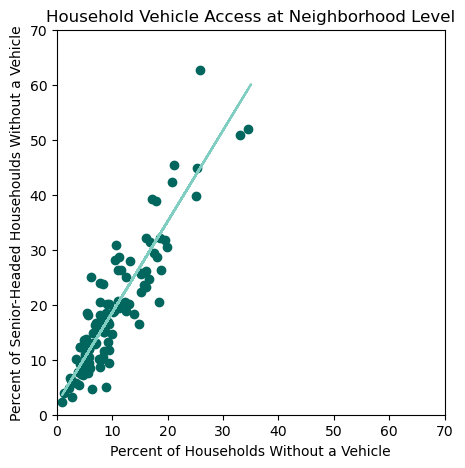

In [23]:
neighborhood_linear=vehicles_by_neighborhood[(vehicles_by_neighborhood["Pct Households Without a Vehicle"]>=0) &
                                      (vehicles_by_neighborhood["Pct Senior-Headed Households Without a Vehicle"]>=0)]

# Create line of best fit.
m, b = np.polyfit(neighborhood_linear["Pct Households Without a Vehicle"], neighborhood_linear["Pct Senior-Headed Households Without a Vehicle"], 1)

fig,ax = plt.subplots(figsize=(5,5))

# Plot scatter plot and line of best fit.
ax = plt.plot(neighborhood_linear["Pct Households Without a Vehicle"], neighborhood_linear["Pct Senior-Headed Households Without a Vehicle"],
              'o', color='#01665e')
ax = plt.plot(neighborhood_linear["Pct Households Without a Vehicle"], m*neighborhood_linear["Pct Households Without a Vehicle"] + b,
             color='#80cdc1')

plt.xlim(0,70)
plt.xlabel("Percent of Households Without a Vehicle")

plt.ylim(0,70)
plt.ylabel("Percent of Senior-Headed Househoulds Without a Vehicle")

plt.title("Household Vehicle Access at Neighborhood Level")

This scatter plot shows that vehicle access and senior vehicle access trend closely, but that seniors are much less likely to own a vehicle. This scatter plot also helps us understand that there are 10 neighborhoods that have particularly high rates of zero-vehicle households (the 10 points far away from the cluster of other points). To understand where these outliers are, we created a bar chart of the top 10 neighborhoods where senior-headed households are the least likely to own a vehicle.

Text(0.5, 1.0, 'Top 10 Neighborhoods by Pct of Senior-Headed Households That Do Not Have Vehicle')

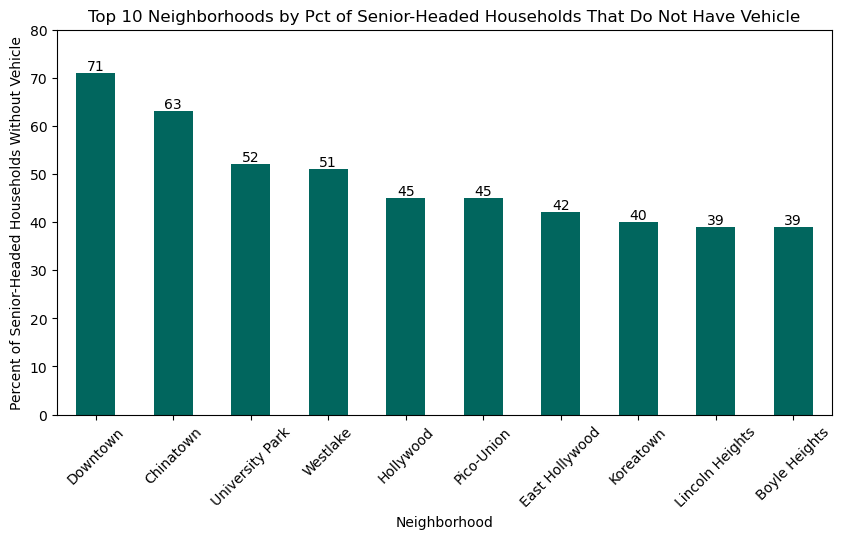

In [24]:
# Create a dataframe for chart with sorted, rounded percentages (so that they can be displayed).
neighborhood_bar=vehicles_by_neighborhood[['neighborhood','Pct Senior-Headed Households Without a Vehicle']].round().sort_values(by=['Pct Senior-Headed Households Without a Vehicle'],ascending=False)

# Start plot.
fig, ax = plt.subplots(figsize=(10,5))
ax = neighborhood_bar[:10].plot(ax=ax, kind='bar', x='neighborhood', y= 'Pct Senior-Headed Households Without a Vehicle', color=['#01665e'], legend=False)
ax.bar_label(ax.containers[0], label_type='edge')

# Adjust x-axis.
plt.xlabel("Neighborhood")
plt.xticks(rotation=45)

# Ajust y-axis.
plt.ylabel("Percent of Senior-Headed Households Without Vehicle")
ax.set_yticks((0,10,20,30,40,50,60,70,80))

#Adjust table and legend.
plt.title("Top 10 Neighborhoods by Pct of Senior-Headed Households That Do Not Have Vehicle")

From this chart, we learn that the neighborhoods where seniors are concentrated in Central and East Los Angeles.

### Part 3: What does grocery store access look like in Los Angeles?

Next, we turn to the question of where chain grocery stores are located within the City of Los Angeles. Although we would prefer to include non-chain grocery stores as well, there's no reasonable way to identify them for the entire City of Los Angeles. We will likely be able to manually include these if we zoom in on a small number of neighborhoods in future analysis. <br>First, we read in the geojson created in the Prep Notebook, which contains information about the grocery stores. For initial analysis, we want to analyze just grocery chains within the municipal border.

In [25]:
# Read file.
grocery_chains=gpd.read_file('chain_with_neighborhood.geojson')

# Create new geodataframe with just chains within the City of LA.
chain_with_neighborhood=grocery_chains[grocery_chains['neighborhood'].notna()].copy().reset_index().drop(columns=['index'])

We want to make a map of grocery stores in Los Angeles categorized by their chain. However, there are too many supermarket chains to map them with every chain as its own category, so I will create a new dataframe for the primary purpose of mapping. This new dataframe will contain a column (chain_map) that contains the chain's name for very big chains, and the chain type for smaller chains. First, I determine what the top 5 chains are.

In [26]:
# Display fist five items in a new dataframe with counts of each chain.
top_chains = chain_with_neighborhood.value_counts(['chain_name']).reset_index(name='count').iloc[:5]
top_chains

chain_name  count
0         Ralphs     43
1         Target     30
2  Smart & Final     30
3   Trader Joe's     22
4    Food 4 Less     21

Now I can use this information to create my new chain_map categories.

In [27]:
#Create new geodataframe for map.
chain_map=chain_with_neighborhood.copy()

# Create new variable that defaults to the chain type.
chain_map['chain_map'] = chain_map['chain_type']

# Replace value with the chain's name for Top 5 Chains.
chain_map.loc[chain_map['chain_name'] == "Ralphs", 'chain_map'] = "Ralphs"
chain_map.loc[chain_map['chain_name'] == "Smart & Final", 'chain_map'] = "Smart & Final"
chain_map.loc[chain_map['chain_name'] == "Target", 'chain_map'] = "Target"
chain_map.loc[chain_map['chain_name'] == "Trader Joe's", 'chain_map'] = "Trader Joe's"
chain_map.loc[chain_map['chain_name'] == "Food 4 Less", 'chain_map'] = "Food 4 Less"

# See how many stores there are in each mapping category.
chainmap_counts = chain_map.value_counts(['chain_map']).reset_index(name='count')
chainmap_counts

chain_map  count
0  Standard chain (e.g. Ralphs, Trader Joe's)    102
1                                      Ralphs     43
2         Upscale (e.g. Whole Foods, Sprouts)     38
3                               Smart & Final     30
4                                      Target     30
5  Discount (e.g. Smart & Final, Food 4 Less)     25
6                                Trader Joe's     22
7                                 Food 4 Less     21
8     Department store (e.g. Target, Walmart)      5

I notice that by pulling the Targets out separately, there aren't enough department stores to map as a category, so I'll fold these into standard chains.

In [28]:
chain_map.loc[chain_map['chain_name'] == "Walmart", 'chain_map'] = "Standard chain (e.g. Ralphs, Trader Joe's)"

Finally, I must rename my categories to remove references to chains that have been pulled out.

In [29]:
chain_map.loc[chain_map['chain_map'] == "Standard chain (e.g. Ralphs, Trader Joe's)", 'chain_map'] = "Other Standard Chain (e.g. Vons)"
chain_map.loc[chain_map['chain_map'] == "Discount (e.g. Smart & Final, Food 4 Less)", 'chain_map'] = "Other Discount Chain (e.g. Mother's Nutritional Center)"
chain_map.loc[chain_map['chain_map'] == "Upscale (e.g. Whole Foods, Sprouts)", 'chain_map'] = "Upscale Chain (e.g. Whole Foods)"

# See how many stores there are in each mapping category.
chainmap_counts = chain_map.value_counts(['chain_map']).reset_index(name='count')
chainmap_counts

chain_map  count
0                   Other Standard Chain (e.g. Vons)    107
1                                             Ralphs     43
2                   Upscale Chain (e.g. Whole Foods)     38
3                                      Smart & Final     30
4                                             Target     30
5  Other Discount Chain (e.g. Mother's Nutritiona...     25
6                                       Trader Joe's     22
7                                        Food 4 Less     21

Now I can create an interactive map that has the locations of each supermarket chain grocery store in the City of LA. This map helps us understand the spatial distribution of chains overall and _which_ chains are in which areas.

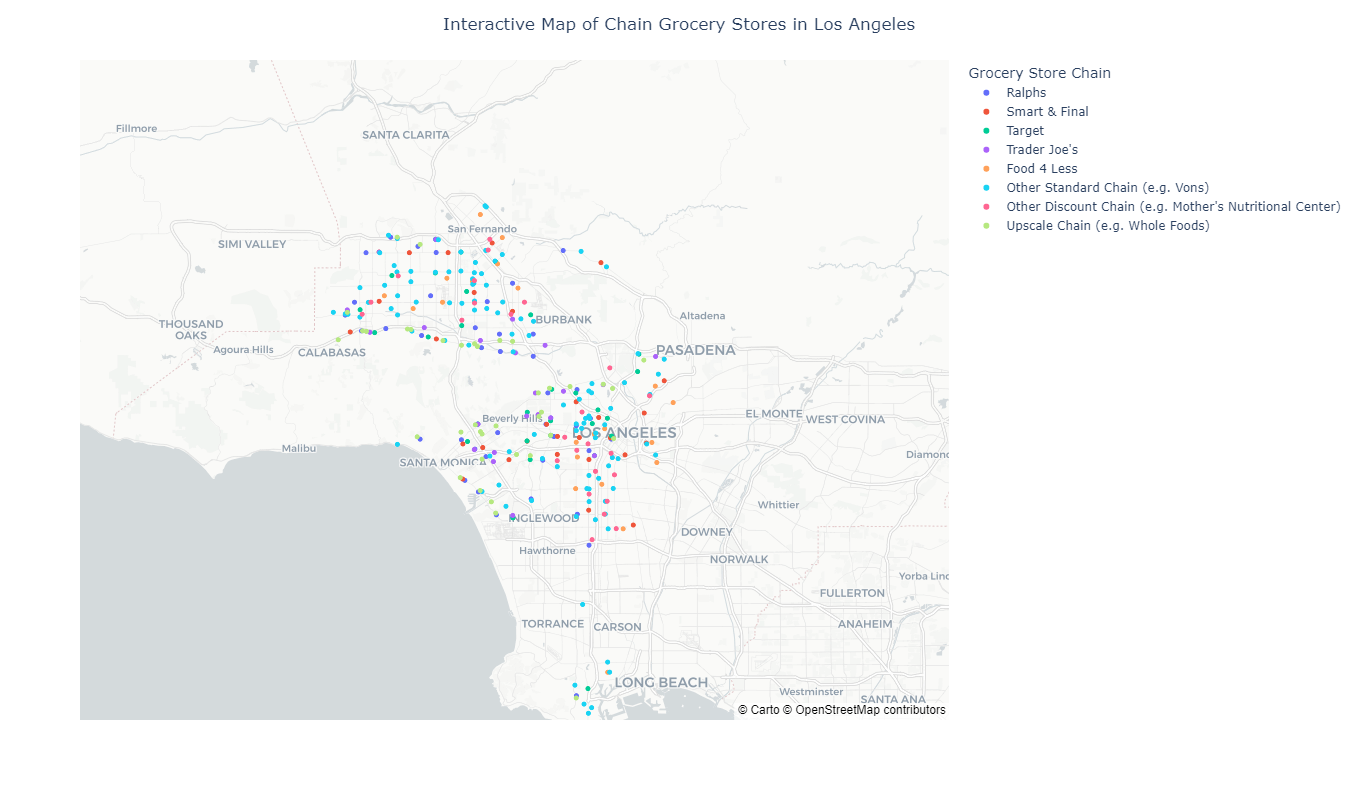

In [30]:
# Create an order column with the desired order (in the legend I want first the top 5 chains in descending order of prevalence and then the chain groups)
chain_map.loc[chain_map['chain_map'] == "Ralphs", 'chain_map_order'] = 1
chain_map.loc[chain_map['chain_map'] == "Smart & Final", 'chain_map_order'] = 2
chain_map.loc[chain_map['chain_map'] == "Target", 'chain_map_order'] = 3
chain_map.loc[chain_map['chain_map'] == "Trader Joe's", 'chain_map_order'] = 4
chain_map.loc[chain_map['chain_map'] == "Food 4 Less", 'chain_map_order'] = 5
chain_map.loc[chain_map['chain_map'] == "Other Standard Chain (e.g. Vons)", 'chain_map_order'] = 6
chain_map.loc[chain_map['chain_map'] == "Other Discount Chain (e.g. Mother's Nutritional Center)", 'chain_map_order'] = 7
chain_map.loc[chain_map['chain_map'] == "Upscale Chain (e.g. Whole Foods)", 'chain_map_order'] = 8

# Sort by my new order column.
chain_map=chain_map.sort_values('chain_map_order')

# Create an interactive map where markers are colored by the name of the chain.
fig = px.scatter_mapbox(chain_map,
                        lat='Latitude',
                        lon='Longitude',
                        color='chain_map',
                        mapbox_style="carto-positron",
                        labels={
                            'chain_map':'Grocery Store Chain',
                        })

# Update layout with desired size, zoom, title, etc.
# Chart specifically must be wider to accomodate the longer names in the legend.
fig.update_layout(
    width = 950,
    height = 800,
    mapbox_style="carto-positron",
    mapbox_zoom=9,
    title = "Interactive Map of Chain Grocery Stores in Los Angeles",
    title_x=0.5)

fig.show()

Exploring this map helps us understand geographic trends - for example, Ralphs has virtually no presence east of Downtown despite being the largest chain in the region. Additionally, you can see very start indications of segregation. While "Discount Chains" are concentrated in South LA, "Upscale Chains" are generally concentrated in West LA and along the 101. These trends are interesting for thinking about grocery store access in terms of affordability in addition to physical accessibility.

Now we turn our attention to the question of which areas are within walking distance of a grocery store. First, we'll read in the geojsons that we'll need, with the most notable one being the dataframe of walksheds created in the Prep Notebook.

In [31]:
# Read the geojson from the prep notebook that has walkshed geometries.
walksheds=gpd.read_file('grocery_walksheds.geojson')

# Read the geojson from the prep notebook that has census block group geometries.
bg_geometries=gpd.read_file('bg_geometries.geojson')

# Import LA City boundary directly from Los Angeles GeoHub. 
cityboundary_proj=gpd.read_file("https://maps.lacity.org/lahub/rest/services/Boundaries/MapServer/7/query?outFields=*&where=1%3D1&f=geojson").to_crs('epsg:6423')

First, we'll create a map to visualize these walksheds.

/opt/conda/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



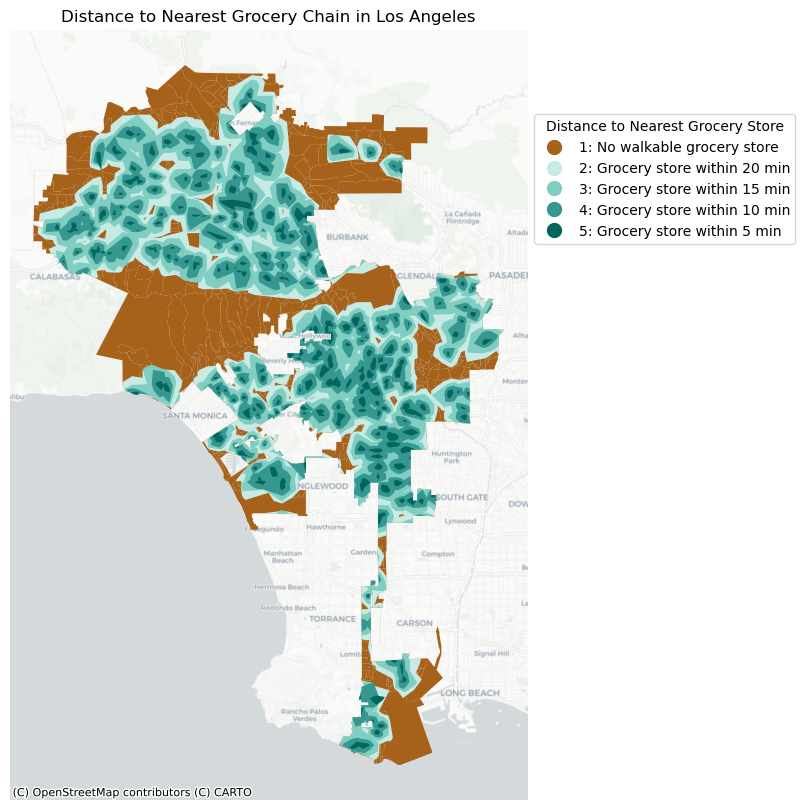

In [32]:
# Walksheds can expand into other municipalities, so we will clip the walkshed to the LA boundary.
walksheds_map=gpd.clip(walksheds, cityboundary_proj).sort_values(by=['time'],ascending=False)

# I am going to have to create a manual legend since I have multiple layers, so I will first create a color dictionary.
color_dict = {'1: No walkable grocery store': '#a6611a',
              '2: Grocery store within 20 min': '#c7eae5',
              '3: Grocery store within 15 min': '#80cdc1',
              '4: Grocery store within 10 min': '#35978f',
              '5: Grocery store within 5 min': '#01665e'}

# Now I create a "colors" column in each separate dataframe that denotes the color I want things to show up as.
walksheds_map.loc[walksheds_map['time']==5, 'colors'] = '#01665e'
walksheds_map.loc[walksheds_map['time']==10, 'colors'] = '#35978f'
walksheds_map.loc[walksheds_map['time']==15, 'colors'] = '#80cdc1'
walksheds_map.loc[walksheds_map['time']==20, 'colors'] = '#c7eae5'
bg_geometries["colors"] = '#a6611a'

# Now I create my actual map with the three geodataframes added in the appropriate order (zorder).
fig,ax = plt.subplots(figsize=(10,10))
#chain_with_neighborhood.plot(ax=ax, zorder=3,color='orange')
walksheds_map.plot(ax=ax, zorder=2, color=walksheds_map['colors'])
bg_geometries.plot(ax=ax, zorder=1, color=bg_geometries['colors'])

# Add manual legend.
from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in color_dict.values()]
ax.legend(custom_points, color_dict.keys(), loc='upper left', bbox_to_anchor=(1,.9), title="Distance to Nearest Grocery Store")

#Format plot axis, title, and basemap.
ax.axis('off')
ax.set_title('Distance to Nearest Grocery Chain in Los Angeles')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='epsg:6423')

To zoom in on this map, we made a function that allows you to produce a map of grocery store access by foot for any neighborhood of Los Angeles.

In [33]:
neighborhoods

OBJECTID            neighborhood  \
0           1         Adams-Normandie   
1           2                  Arleta   
2           3       Arlington Heights   
3           4         Atwater Village   
4           5  Baldwin Hills/Crenshaw   
..        ...                     ...   
109       110              Wilmington   
110       111          Windsor Square   
111       112                Winnetka   
112       113          Woodland Hills   
113       114             Lake Balboa   

                                              geometry  
0    POLYGON ((1972233.388 559643.685, 1971938.035 ...  
1    POLYGON ((1959244.309 584850.051, 1959257.540 ...  
2    POLYGON ((1970582.552 561395.372, 1970757.410 ...  
3    MULTIPOLYGON (((1974284.934 572493.221, 197428...  
4    POLYGON ((1966656.952 558331.179, 1966727.113 ...  
..                                                 ...  
109  MULTIPOLYGON (((1973750.208 528359.208, 197331...  
110  POLYGON ((1971009.063 562446.138, 1970993.538 ...  
111  POLYGON ((1948194.285 581341.255, 1948194.206 ...  
112  POLYGON ((1947236.943 576320.529, 1947309.537 ...  
113  POLYGON ((1953822.665 580107.579, 1953821.348 ...  

[114 rows x 3 columns]

In [34]:
def neighborhood_map(map_neighborhood='Palms'):
    neighborhood_boundary=neighborhoods[neighborhoods['neighborhood']==map_neighborhood]
    neighborhood_walkshed=gpd.overlay(walksheds_map,neighborhood_boundary,how='intersection', keep_geom_type=None, make_valid=True)
    neighborhood_stores=gpd.clip(grocery_chains,neighborhood_boundary)

    # Make plot:
    color_dict = {'1: No walkable grocery store': '#a6611a',
                  '2: Grocery store within 20 min': '#c7eae5',
                  '3: Grocery store within 15 min': '#80cdc1',
                  '4: Grocery store within 10 min': '#35978f',
                  '5: Grocery store within 5 min': '#01665e',
                  '6: Grocery store location' : 'lightgrey'}

    neighborhood_walkshed.loc[neighborhood_walkshed['time']==5, 'colors'] = '#01665e'
    neighborhood_walkshed.loc[neighborhood_walkshed['time']==10, 'colors'] = '#35978f'
    neighborhood_walkshed.loc[neighborhood_walkshed['time']==15, 'colors'] = '#80cdc1'
    neighborhood_walkshed.loc[neighborhood_walkshed['time']==20, 'colors'] = '#c7eae5'
    neighborhood_boundary["colors"] = '#a6611a'

    fig, ax= plt.subplots(figsize=(8,8))
    neighborhood_walkshed.plot(ax=ax,zorder=2,color=walksheds_map['colors'])
    neighborhood_boundary.plot(ax=ax,zorder=1,color=neighborhood_boundary['colors'])
    neighborhood_stores.plot(ax=ax,zorder=3,marker='x',color='lightgrey')

    from matplotlib.lines import Line2D
    custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in color_dict.values()]
    ax.legend(custom_points, color_dict.keys(), loc='upper left', bbox_to_anchor=(1,.9), title="Distance to Nearest Grocery Store")

    ax.axis('off')
    ax.set_title('Distance to Nearest Grocery Store in '+map_neighborhood)
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='epsg:6423')

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



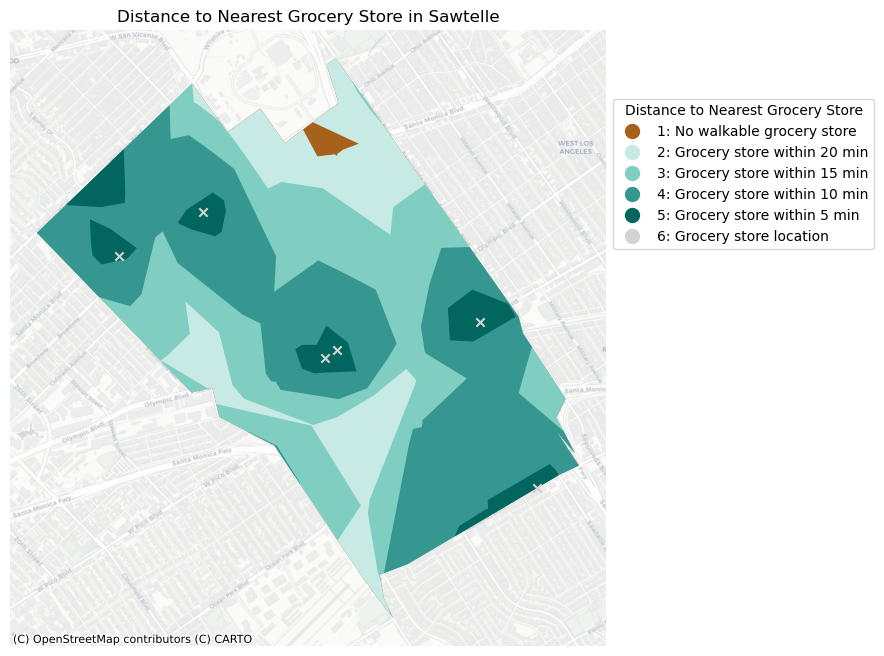

In [35]:
neighborhood_map('Sawtelle')

Now we'll determine which block groups "have access." We would prefer to proportionally allocate the population of each census block groups. However, for this project, we believe that the best way to approximate which block groups have access is by determining whether or not the centroid of the block group falls within the walkshed. Based on prior work, we believe that this is the best way to allocate entire block groups (rather than block group intersections) for a couple of reasons:
1) It more closely aligns with the spatial extent of the actual walksheds than using all block groups that intersect with the walkshed at all
2) Since we're talking about a vulnerable population in which many people have mobility limitations, we want to air on the side of underestimating access rather than overestimating access. 

First we will calculate each block group's centroid.

In [36]:
# Create a new dataframe to store information about grocery store access to a census block group's centroid.
bg_centroids=bg_geometries.copy()

# Create a centroid column with a geopandas calculation.
bg_centroids['centroid']=bg_centroids.centroid

# Make my new centroid column the primary geometry for the geodataframe. 
bg_centroids=bg_centroids.set_geometry('centroid')

Now we can join the walksheds to the census centroids.

In [37]:
#Join in the geodataframe of walksheds.
bg_access=bg_centroids.sjoin(walksheds, how="left")

#Remove duplicate BG caused by doing a left join but be sure to keep "best" walk access.
bg_access = bg_access.fillna(25).sort_values(by=['time'], ascending=True).drop_duplicates(subset='BG20', keep="first")

# Return block group boundary to being the primary geometry.
bg_access=bg_access.set_geometry('geometry')

Finally I use the columns that have been joined to categorize each census block groups based on how far away the nearest grocery chain is.

In [38]:
bg_access['grocery_walkable']= '1: No walkable grocery store'
bg_access.loc[bg_access['time']==20, 'grocery_walkable'] = '2: Grocery store within 20 min'
bg_access.loc[bg_access['time']==15, 'grocery_walkable'] = '3: Grocery store within 15 min'
bg_access.loc[bg_access['time']==10, 'grocery_walkable'] = '4: Grocery store within 10 min'
bg_access.loc[bg_access['time']==5, 'grocery_walkable'] = '5: Grocery store within 5 min'

Finally, I map my census tracts, categorized by their walk access to grocery stores.

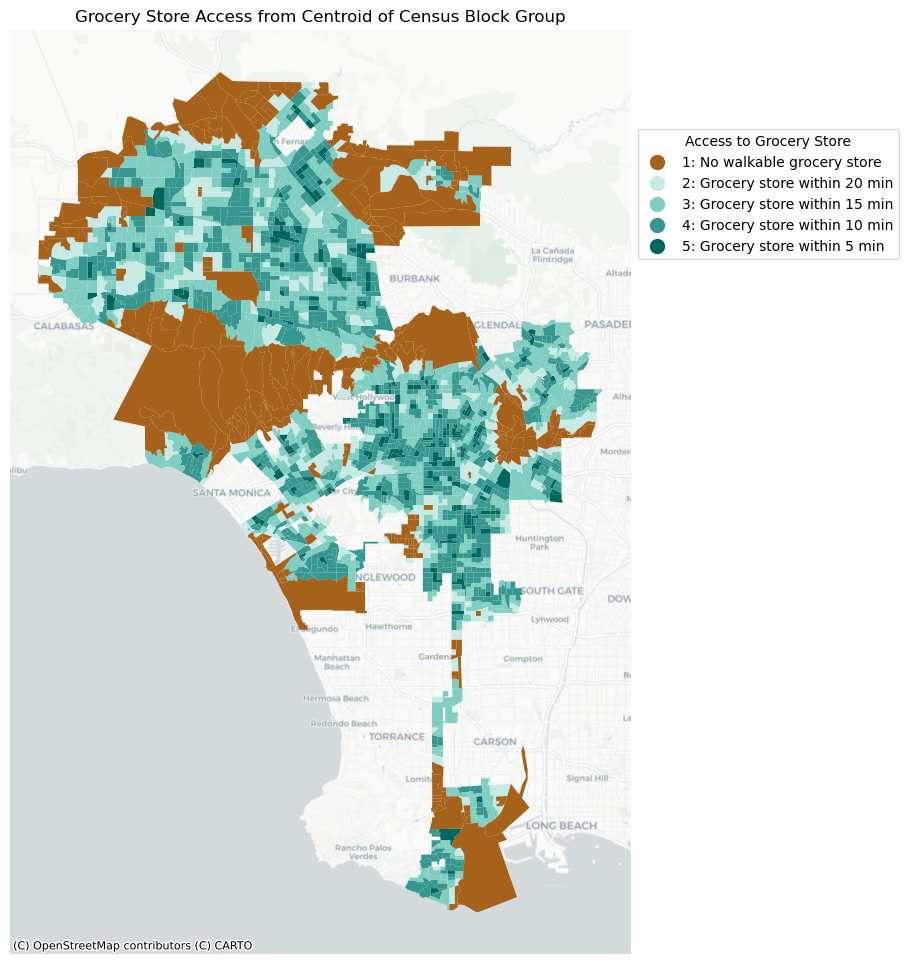

In [39]:
#Plot the block groups that allegedly have access and the grocery store locations.

# Since Python doesn't want me to specific a color and a colomn within the same plot, I'll first create a color column and then a manual legend.
color_dict = {'1: No walkable grocery store': '#a6611a',
              '2: Grocery store within 20 min': '#c7eae5',
              '3: Grocery store within 15 min': '#80cdc1',
              '4: Grocery store within 10 min': '#35978f',
              '5: Grocery store within 5 min': '#01665e'}

bg_access["colors"] = bg_access["grocery_walkable"].map(color_dict)


fig,ax = plt.subplots(figsize=(12,12))
ax = bg_access.plot(ax=ax, color = bg_access["colors"])

# Add manual legend
from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in color_dict.values()]
ax.legend(custom_points, color_dict.keys(), loc='upper left', bbox_to_anchor=(1,.9), title="Access to Grocery Store")

#Format plot.
ax.axis('off')
ax.set_title('Grocery Store Access from Centroid of Census Block Group')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='epsg:6423')

Finally, we can use this information to do some basic calculations about how likely Seniors are to live within walking distance of a grocery chain, and whether they have worse (or better) acess than the general population of Los Angeles.

In [40]:
# Read file.
seniors=gpd.read_file('Percent_Senior_Basemap.geojson')

# Keep just necessary columns.
seniors=seniors[['BG20','Total Pop','Total Senior Pop']]
seniors.head()

BG20  Total Pop  Total Senior Pop
0  2742023        740                13
1  2739025        763               158
2  2739024        998               100
3  2739023       1098               240
4  2735023        923                69

To simplify high-level analysis at this stage, we will create a binary access categorization that considers a block group as having walk access to a grocery store if it's within 10 minutes.

In [41]:
access_simplififed=bg_access.copy()
access_simplififed.loc[access_simplififed['time']==20, 'grocery_walkable'] = '1: No walkable grocery store'
access_simplififed.loc[access_simplififed['time']==15, 'grocery_walkable'] = '1: No walkable grocery store'
access_simplififed.loc[access_simplififed['time']==10, 'grocery_walkable'] = '2: Grocery store within 10 min'
access_simplififed.loc[access_simplififed['time']==5, 'grocery_walkable'] = '2: Grocery store within 10 min'

In [42]:
# Merge info on number of seniors with grocery store access table.
senior_access=pd.merge(access_simplififed, seniors, how="left", on=["BG20"])

First, I want to create a new table that sums up all of the data across all block groups, so that I can conduct calculations about what percentage of Seniors and All Residents live within walking distance of a grocery store for the City of Los Angeles as a whole.

In [43]:
# Sum up all of the data for all of the block groups in each category.
senior_sums = senior_access.groupby(by='grocery_walkable').sum(numeric_only=True)

# Keep just the columns that we're interested in.
senior_sums=senior_sums[['Total Pop','Total Senior Pop']].reset_index(names='grocery_walkable')

# Create calculated columns. 
senior_sums['All Population']=round(senior_sums['Total Pop']/(senior_sums['Total Pop'].sum())*100)
senior_sums['Seniors']=round(senior_sums['Total Senior Pop']/(senior_sums['Total Senior Pop'].sum())*100)

# Create calculated columns. 
senior_sums['All Population']=round(senior_sums['Total Pop']/(senior_sums['Total Pop'].sum())*100)
senior_sums['Seniors']=round(senior_sums['Total Senior Pop']/(senior_sums['Total Senior Pop'].sum())*100)

# Drop columns that are no longer necessary now that calculation has been completed.
senior_sums=senior_sums.drop(columns=['Total Pop', 'Total Senior Pop'])

# Take a look at our table.
senior_sums

grocery_walkable  All Population  Seniors
0    1: No walkable grocery store            56.0     59.0
1  2: Grocery store within 10 min            44.0     41.0

To be able to easily plot this, we have to transpose this table.

In [44]:
# Transpose table.
senior_sums=senior_sums.transpose()

# Move column names from row 0 to columns.
senior_sums.columns = senior_sums.iloc[0]

# Now drop row 0 now that column names have been successfully extracted.
senior_sums = senior_sums.iloc[1:]

# Take a look at our table.
senior_sums

grocery_walkable 1: No walkable grocery store 2: Grocery store within 10 min
All Population                           56.0                           44.0
Seniors                                  59.0                           41.0

Now we can create our bar plot.

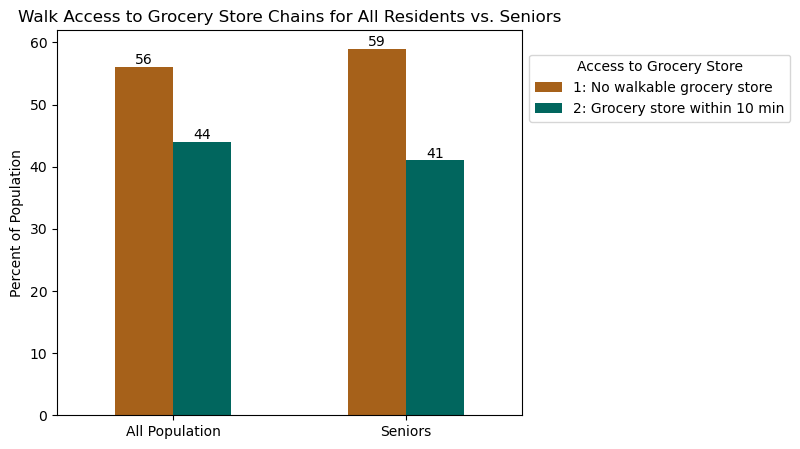

In [45]:
# Now I plot the pivot table.
fig, ax = plt.subplots(figsize=(6,5))

ax = senior_sums.plot(ax=ax, kind='bar',color=['#a6611a', '#01665e'] , legend=True)
ax.bar_label(ax.containers[0], label_type='edge')
ax.bar_label(ax.containers[1], label_type='edge')

# Adjust x-axis.
plt.xlabel(None)
plt.xticks(rotation=0)

# Ajust y-axis.
plt.ylabel("Percent of Population")

#Adjust table and legend.
plt.title("Walk Access to Grocery Store Chains for All Residents vs. Seniors")
plt.legend(loc='center left', bbox_to_anchor=(1, .85), title='Access to Grocery Store')

plt.show()

We can see from this chart that Seniors are more likely to live in a census block group that does not have a walkable grocery store (59% compared to 56%).

The final step is to understand which neighborhoods have particularly low access for seniors. We use a pivot table to calculate the percentage of seniors who are not within walking distance of a grocery store by neighborhood.

In [46]:
import numpy as np
# First I create a pivot table.
access_by_neighborhood = pd.pivot_table(senior_access, 
                          values="Total Senior Pop", 
                          index="neighborhood", 
                          columns="grocery_walkable", 
                          aggfunc=np.sum)
access_by_neighborhood=access_by_neighborhood.reset_index()

# Fill NA with 0.
access_by_neighborhood['1: No walkable grocery store']=access_by_neighborhood['1: No walkable grocery store'].fillna(0)
access_by_neighborhood['2: Grocery store within 10 min']=access_by_neighborhood['2: Grocery store within 10 min'].fillna(0)

# Now I calculate percentages
access_by_neighborhood['Total_Senior_Pop']=access_by_neighborhood['1: No walkable grocery store']+access_by_neighborhood['2: Grocery store within 10 min']
access_by_neighborhood['Pct_No_Grocery_Walkable']=round((access_by_neighborhood['1: No walkable grocery store']/
                                               (access_by_neighborhood['1: No walkable grocery store']+access_by_neighborhood['2: Grocery store within 10 min']))*100)

# Remove percentages for places with virtually no people.
#access_by_neighborhood.loc[access_by_neighborhood['Total_Senior_Pop']< 50,  'Pct_No_Grocery_Walkable'] = None

# Add back in geometries.
access_by_neighborhood=pd.merge(access_by_neighborhood, neighborhoods[['neighborhood','geometry']], how="left", on=["neighborhood"]).set_geometry('geometry')

There are too many neighborhoods with nearly 100% of residents living outside of walking distance of a grocery store for a bar chart to be useful. Instead, we will use a map to understand the locations of the 25 neighborhoods with the lowest grocery store access for seniors.

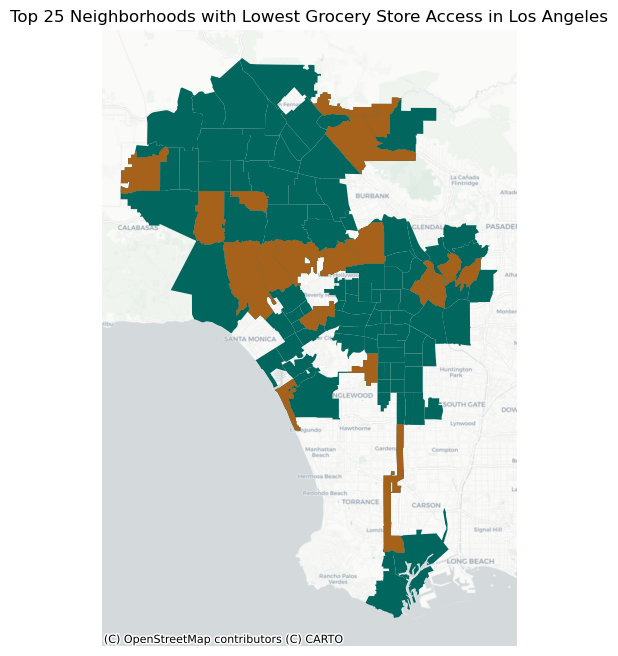

In [47]:
# Quick plot to see how things are going.
fig, ax= plt.subplots(figsize=(8,8))
access_by_neighborhood.sort_values('Pct_No_Grocery_Walkable',ascending=False).iloc[0:25].plot(ax=ax, zorder=2, color='#a6611a')
access_by_neighborhood.plot(ax=ax, zorder=1, color='#01665e')

#Format plot.
ax.axis('off')
ax.set_title('Top 25 Neighborhoods with Lowest Grocery Store Access in Los Angeles')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs='epsg:6423')

### Part 4: What is the distribution of public transit like in LA? 
In this section, we will look at density of transit stops in the city of Los Angeles, and how that relates to where senior residents are living. We aim to identify whether/where there areas where there are high numbers of senior residents, and comparatively low density of transit options.

First we import data on neighborhood boundaries, transit stop locations, transity stop density, and senior population. The transit stop density and location files are compilations of data developed for the midterm, and saved as files for future use.

In [48]:
# Reset senior basemap.
seniors = gpd.read_file('data/Seniors_Basemap.geojson')

In [49]:
#read in transit stop data and create dataframes

#Spatial data for public transit stops in City of LA
transit_stops = gpd.read_file('data/transit_stops.geojson')
#Information on number of public transit stops per 
transit_density = pd.read_csv('data/transit_stopcount.csv')
lowtransitdensebg = gpd.read_file('data/lowdensityblockgroups.geojson')
hightransitdensebg= gpd.read_file('data/highdensityblockgroups.geojson')

#read in LA Times Neighborhood Boundaries 
neighborhoods = gpd.read_file('data/LA_Times_Neighborhood_Boundaries.geojson')

### Map of Transit Stop Locations and Senior Density

First, we look at where public transit stops are located in LA, and how that compares to where seniors are most densely located.

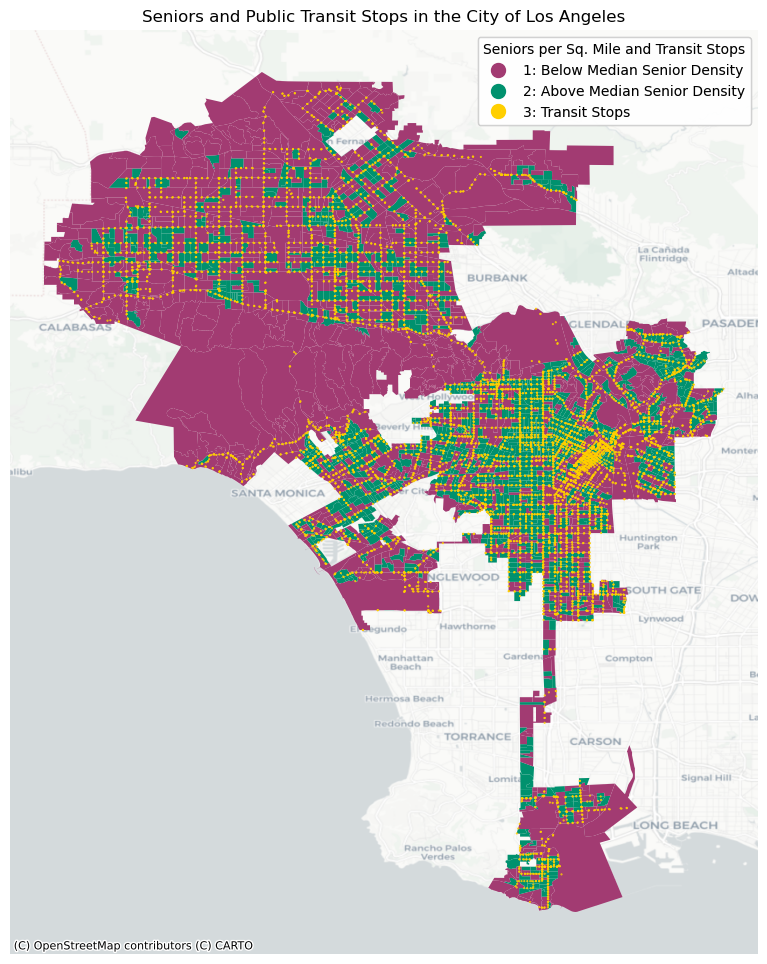

In [50]:
# I am going to have to create a manual legend since I have multiple layers, so I will first create a color dictionary.
color_dict = {'1: Below Median Senior Density': '#A23B72',
 '2: Above Median Senior Density': '#00916E',
 '3: Transit Stops': '#FFCF00'}

# Now I create a "colors" column in each separate dataframe that denotes the color I want things to show up as.

seniors.loc[seniors["Pop Density"] < 135.000000, "colors"]= '#A23B72' 
seniors.loc[seniors["Pop Density"] >= 135.000000, "colors"]= '#00916E' 
transit_stops["colors"] = '#FFCF00'

#Plot Bus Stops and Metro Stops on top of Senior Population Density
fig,ax = plt.subplots(figsize=(12,12))
ax1=seniors.plot(ax=ax,zorder=1,color=seniors['colors'])

#plot LA metro bus stops
ax2=transit_stops.plot(ax=ax, zorder=2, marker='.',markersize=1,legend=True,color=transit_stops['colors'])
                                                                                                
# Add manual legend.
from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in color_dict.values()]
leg_points = ax.legend(custom_points, color_dict.keys(), title="Seniors per Sq. Mile and Transit Stops")
ax.add_artist(leg_points)


#Format plot.
ax.axis('off')
ax.set_title('Seniors and Public Transit Stops in the City of Los Angeles')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=4326)

### Map of Density of Transit Stops

Next, we look at density of transit stops to get a better spatial metric. The following map shows block groups in the top and bottom quartiles (highest and lowest) of transit stops/block group. This can help provide a visual of areas that might be good to focus in on for futher analysis.

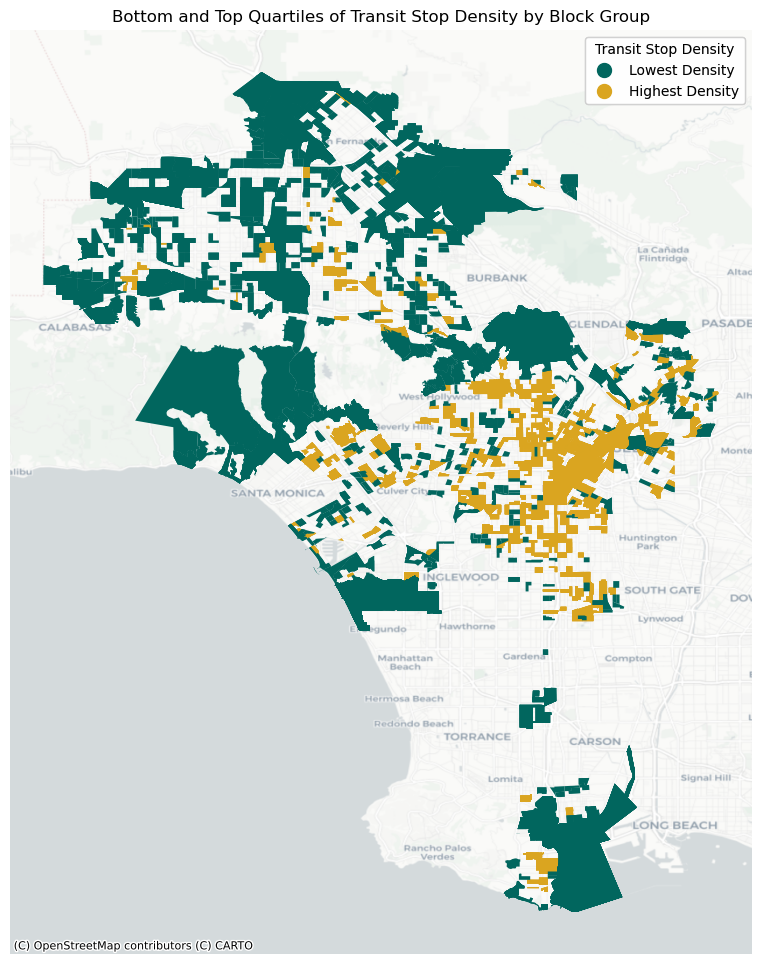

In [51]:
# Add manual legend
color_dict = {'Lowest Density': '#01665e',
 'Highest Density': '#DAA520'}

# Now I create a "colors" column in each separate dataframe that denotes the color I want things to show up as.
lowtransitdensebg["colors"] = '#01665e'
hightransitdensebg["colors"] = '#DAA520'

# Now I create my actual map with the three geodataframes added in the appropriate order (zorder).
fig,ax = plt.subplots(figsize=(12,12))
lowtransitdensebg.plot(ax=ax, zorder=2, color=lowtransitdensebg['colors'])
hightransitdensebg.plot(ax=ax, zorder=1, color=hightransitdensebg['colors'])

# Add manual legend.
from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in color_dict.values()]
leg_points = ax.legend(custom_points, color_dict.keys(), title="Transit Stop Density")
ax.add_artist(leg_points)

#Format plot.
ax.axis('off')
ax.set_title('Bottom and Top Quartiles of Transit Stop Density by Block Group')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=4326)

### Scaling Up to Neighborhoods

Since we hope to pick several neighborhoods to focus in on for more analysis, we need to connect this information to neighborhood boundaries.

In [52]:
#What are the unique neighborhood names? 
neighborhoods.name.unique()

array(['Adams-Normandie', 'Arleta', 'Arlington Heights',
       'Atwater Village', 'Baldwin Hills/Crenshaw', 'Bel-Air',
       'Beverly Crest', 'Beverly Grove', 'Beverlywood', 'Boyle Heights',
       'Brentwood', 'Broadway-Manchester', 'Canoga Park', 'Carthay',
       'Central-Alameda', 'Century City', 'Chatsworth',
       'Chatsworth Reservoir', 'Chesterfield Square', 'Cheviot Hills',
       'Chinatown', 'Cypress Park', 'Del Rey', 'Downtown', 'Eagle Rock',
       'East Hollywood', 'Echo Park', 'El Sereno', 'Elysian Park',
       'Elysian Valley', 'Encino', 'Exposition Park', 'Fairfax',
       'Florence', 'Glassell Park', 'Gramercy Park', 'Granada Hills',
       'Green Meadows', 'Griffith Park', 'Hancock Park', 'Hansen Dam',
       'Harbor City', 'Harbor Gateway', 'Harvard Heights', 'Harvard Park',
       'Highland Park', 'Historic South-Central', 'Hollywood Hills',
       'Hollywood Hills West', 'Hollywood', 'Hyde Park', 'Jefferson Park',
       'Koreatown', 'Lake View Terrace', 'Larc

We will join the transit_stops geodataframe to the LA neighborhood boundaries.

In [53]:
#spatial join of transit stop locations and neighborhood boundaries
transit_stops_nbrhood = gpd.sjoin(transit_stops, neighborhoods)
#display
transit_stops_nbrhood.sample(1)

stopid      stopname                     geometry   colors  index_right  \
2344  90431  Grand & 14th  POINT (-118.26547 34.03710)  #FFCF00           23   

      OBJECTID      name  
2344        24  Downtown

In [54]:
#Use valuecounts to get the number of unique stops per neighborhood
transit_nbrhood_count= transit_stops_nbrhood.value_counts(['name']).reset_index(name='stop_count')
#display statistics 
transit_nbrhood_count.describe()

stop_count
count  113.000000
mean    90.398230
std     94.149533
min      2.000000
25%     37.000000
50%     71.000000
75%    117.000000
max    850.000000

In [55]:
#Create dataframe of lowest quartile of # of transit stops/neighborhood.
low25_nbhd = transit_nbrhood_count[transit_nbrhood_count["stop_count"] < 37.000000]
#rename columns for plotting
low25_nbhd = low25_nbhd.rename(columns={'stop_count': 'Number of Public Transit Stops', 'name': 'Neighborhood'})

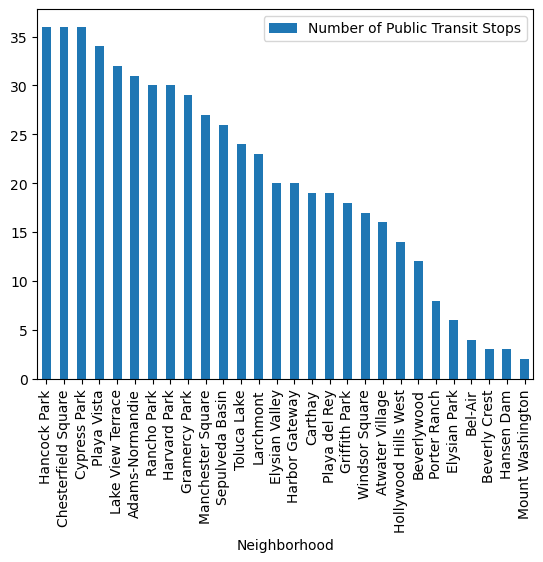

In [56]:
#Plot bar graph
ax = low25_nbhd.plot.bar(x='Neighborhood', y='Number of Public Transit Stops', rot=90)

A next step will include calculating area of the neighborhood boundary polygons and adding a density column to the neighborhood transit stop dataframe, so that we can identify neighborhoods with the lowest geographic density of public transit stops. 

### Neighborhood Prioritization

Potential Method 1: Index from 0 to 100.

In [57]:
neighborhood_seniors['Senior_Index']=(neighborhood_seniors['Pct Seniors']-neighborhood_seniors['Pct Seniors'].min())*100/(
    neighborhood_seniors['Pct Seniors'].max()-neighborhood_seniors['Pct Seniors'].min())

vehicles_by_neighborhood['Vehicle_Index']=(vehicles_by_neighborhood['Pct Senior-Headed Households Without a Vehicle']-vehicles_by_neighborhood['Pct Senior-Headed Households Without a Vehicle'].min())*100/(
    vehicles_by_neighborhood['Pct Senior-Headed Households Without a Vehicle'].max()-vehicles_by_neighborhood['Pct Senior-Headed Households Without a Vehicle'].min())

transit_nbrhood_count['Stop_Index']=-(transit_nbrhood_count['stop_count']-transit_nbrhood_count['stop_count'].min())*100/(
    transit_nbrhood_count['stop_count'].max()-transit_nbrhood_count['stop_count'].min())+100
transit_nbrhood_count=transit_nbrhood_count.rename(columns={'name':'neighborhood'})

access_by_neighborhood['Grocery_Index']=access_by_neighborhood['Pct_No_Grocery_Walkable']

In [58]:
neighborhood_priority=pd.merge(neighborhood_seniors[['neighborhood','geometry','Senior_Index']],vehicles_by_neighborhood[['neighborhood','Vehicle_Index']],on=['neighborhood'],how='left')
neighborhood_priority=pd.merge(neighborhood_priority,access_by_neighborhood[['neighborhood','Grocery_Index']],on=['neighborhood'],how='left')
neighborhood_priority=pd.merge(neighborhood_priority,transit_nbrhood_count[['neighborhood','Stop_Index']],on=['neighborhood'],how='left')
neighborhood_priority['Priority_Index']=(neighborhood_priority['Senior_Index']+neighborhood_priority['Vehicle_Index']+neighborhood_priority['Grocery_Index']+neighborhood_priority['Stop_Index'])/4
neighborhood_priority=neighborhood_priority.sort_values(by=['Priority_Index'],ascending=False)
neighborhood_priority.iloc[0:15]

neighborhood                                           geometry  \
91          Chinatown  POLYGON ((-118.22473 34.06758, -118.22703 34.0...   
0       Beverly Crest  POLYGON ((-118.42910 34.07920, -118.42929 34.0...   
41       Elysian Park  POLYGON ((-118.24246 34.09391, -118.24057 34.0...   
22    Sepulveda Basin  POLYGON ((-118.47144 34.16192, -118.47241 34.1...   
31     Pico-Robertson  POLYGON ((-118.37731 34.06095, -118.37728 34.0...   
4        Shadow Hills  MULTIPOLYGON (((-118.27059 34.23274, -118.2698...   
12            Sunland  POLYGON ((-118.29941 34.27623, -118.29954 34.2...   
3       Cheviot Hills  POLYGON ((-118.39888 34.04426, -118.39879 34.0...   
8             Tarzana  POLYGON ((-118.52729 34.17083, -118.52724 34.1...   
10            Tujunga  POLYGON ((-118.26682 34.23068, -118.26882 34.2...   
5        Porter Ranch  POLYGON ((-118.52951 34.25727, -118.55873 34.2...   
34  Lake View Terrace  POLYGON ((-118.38741 34.29824, -118.38740 34.2...   
13     Windsor Square  POLYGON ((-118.31404 34.06254, -118.31420 34.0...   
7           Brentwood  POLYGON ((-118.49014 34.13096, -118.49009 34.1...   
38     Elysian Valley  POLYGON ((-118.24974 34.10843, -118.24951 34.1...   

    Senior_Index  Vehicle_Index  Grocery_Index  Stop_Index  Priority_Index  
91     30.978261      87.913858          100.0   88.679245       76.892841  
0     100.000000       5.954032          100.0   99.882075       76.459027  
41     51.086957      43.421752          100.0   99.528302       73.509253  
22     61.956522      33.030442          100.0   97.169811       73.039194  
31     56.521739      38.273655          100.0   95.518868       72.578565  
4      86.956522       7.110875          100.0   95.047170       72.278642  
12     72.282609      20.440970           90.0   95.518868       69.560612  
3      90.760870       2.360568           85.0   95.636792       68.439558  
8      76.086957      19.455004           84.0   93.514151       68.264028  
10     73.369565      26.026429           75.0   94.575472       67.242867  
5      84.239130       1.357189           81.0   99.292453       66.472193  
34     54.347826      14.594825          100.0   96.462264       66.351229  
13     72.282609       9.017190           84.0   98.231132       65.882733  
7      79.347826       9.000852           86.0   89.150943       65.874905  
38     52.173913      11.878257          100.0   97.877358       65.482382

In [59]:
def priorityplt(num):
    fig,ax = plt.subplots(figsize=(8,8))
    neighborhood_priority.iloc[0:num].plot(ax=ax,color='darkgreen')
    micro.plot(ax=ax,color='grey')
    ax.axis('off')
    ax.set_title('Top '+str(num)+' Highest Scoring Neighborhoods')
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=4326)

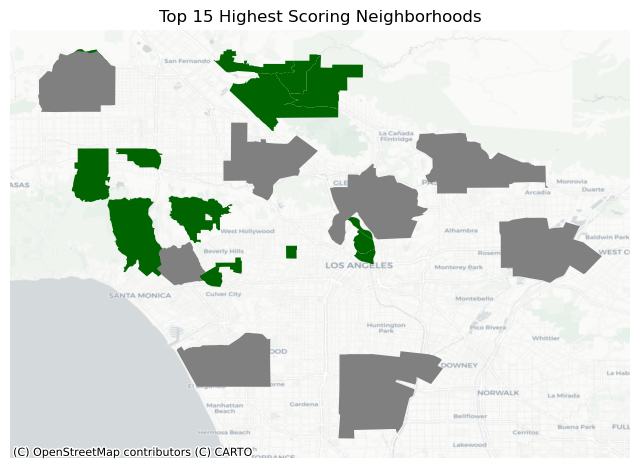

In [60]:
priorityplt(15)

Potential Method 2: Scores above a certain point (here is city-wide average) on every metric.

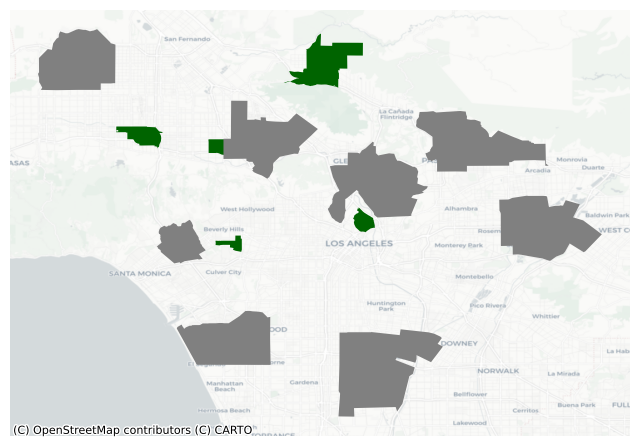

In [63]:
neighborhood_priority2=pd.merge(neighborhood_seniors[['neighborhood','geometry','Pct Seniors']],vehicles_by_neighborhood[['neighborhood','Pct Senior-Headed Households Without a Vehicle']],on=['neighborhood'],how='left')
neighborhood_priority2=pd.merge(neighborhood_priority2,access_by_neighborhood[['neighborhood','Pct_No_Grocery_Walkable']],on=['neighborhood'],how='left')
neighborhood_priority2=pd.merge(neighborhood_priority2,transit_nbrhood_count[['neighborhood','stop_count']],on=['neighborhood'],how='left')

top_priority=neighborhood_priority2[neighborhood_priority2['Pct Seniors']>13]
top_priority=top_priority[top_priority['Pct Senior-Headed Households Without a Vehicle']>20]
top_priority=top_priority[top_priority['Pct_No_Grocery_Walkable']>60]
top_priority=top_priority[top_priority['stop_count']<71]


fig,ax = plt.subplots(figsize=(8,8))
top_priority.plot(ax=ax,color='darkgreen')
micro.plot(ax=ax,color='grey')
ax.axis('off')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=4326)

### Division of Labor:
<b>Carolyn:</b> Carolyn focused on analyses related to fixed route transit.<br>
<b>Lucy:</b> Lucy focused on analyses related to the senior population and Metro Micro zones.<br>
<b>Monisha:</b> Monisha focused on analyses related to household vehicle access and grocery store access.